In [324]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2
import requests
import json

In [325]:
# Global Path Vairables
ROOT_DIR =  "drive/MyDrive/11877-AMMML/"
DATASET_DIR = ROOT_DIR + "dataset/random/"

# Load imagenet classes
with open(DATASET_DIR + "imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())

In [326]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

# define a 1 image dataset
dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=True, batch_size=1)

# get the image from the dataloader
img, _ = next(iter(dataloader))

In [327]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [328]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the most likely prediction of the model
pred = vgg(img)

index = pred.argmax(dim=1).numpy()[0]

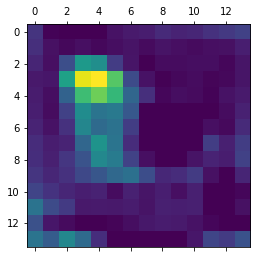

In [329]:
# pull the gradients out of the model
pred[:, index].backward()

gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


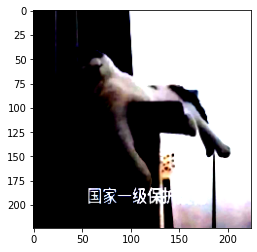

In [330]:
plt.imshow(img[0].permute(1, 2, 0))

In [332]:
plot_image = cv2.imread(DATASET_DIR + 'cat/feiwu.jpg')
# plot_image = img[0].permute(1, 2, 0).numpy()
updated_heatmap = cv2.resize(np.array(heatmap), (plot_image.shape[1], plot_image.shape[0]))
updated_heatmap = np.uint8(255 * updated_heatmap)
updated_heatmap = cv2.applyColorMap(updated_heatmap, cv2.COLORMAP_JET)
superimposed_img = updated_heatmap *0.5 + plot_image

In [333]:
plot_image.shape

(1004, 1170, 3)

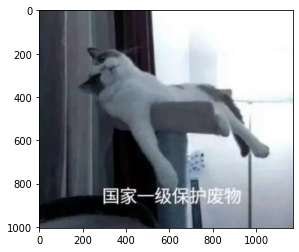

In [334]:
plt.imshow(plot_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted index is 284 and predicted class is Siamese cat, Siamese


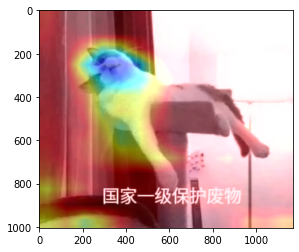

In [335]:
plt.imshow(superimposed_img / 255)
print("Predicted index is", index, "and predicted class is", idx2label[index])